In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans 
from sklearn.manifold import TSNE

import warnings 

warnings.simplefilter("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
train = pd.read_csv(r"C:\Users\lenkovnn\Desktop\Project_ML\data\clustering\train.csv")
test = pd.read_csv(r"C:\Users\lenkovnn\Desktop\Project_ML\data\clustering\test.csv")
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure,cluster
0,1,1,20,50,0.000000,0.083334,0,5.837492,1
1,2,1,20,50,0.033652,18.383041,0,5.907794,1
2,3,1,20,50,0.067514,22.509278,0,7.876254,1
3,4,1,20,50,0.101542,22.808822,0,11.742872,1
4,5,1,20,50,0.135756,25.355850,0,12.234987,1


In [3]:
'''
Before cluster classification, average u_in that correlates
with the constant objective variable of the time stamp by each breath_id.
'''

def class_time_step(x):
    if x < 1.0:
        return 0
    elif x < 1.5:
        return 1
    else:
        return 2
    
train["log_u_in"] = np.log1p(train.u_in)
test["log_u_in"] = np.log1p(test.u_in)

train["time_step_class"] = train.time_step.apply(class_time_step)
test["time_step_class"] = test.time_step.apply(class_time_step)

piv = train.pivot_table(index="breath_id", columns="time_step_class", values="log_u_in", fill_value=0, aggfunc="mean")
piv_test = test.pivot_table(index="breath_id", columns="time_step_class", values="log_u_in", fill_value=0, aggfunc="mean")

piv.head()

time_step_class,0,1,2
breath_id,,,
1,3.054744,0.000000,1.623373
2,2.183309,0.027139,1.646916
3,2.261596,0.000000,1.555113
4,2.282772,0.000000,1.565501
5,3.238464,0.010017,1.638008


# PCA

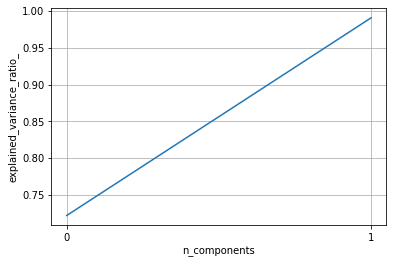

In [4]:
pca = PCA(n_components=2, random_state=42)
pca.fit(piv)

plt.plot(pca.explained_variance_ratio_.cumsum())
plt.grid()
plt.xlabel("n_components")
plt.ylabel("explained_variance_ratio_")
plt.xticks([0, 1])
plt.show()

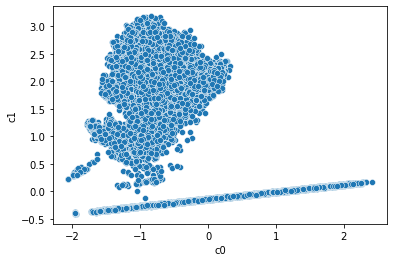

In [5]:
train_pca = pca.transform(piv)
test_pca = pca.transform(piv_test)

train_pca = pd.DataFrame(train_pca, columns=["c"+str(c) for c in range(2)], index=piv.index)
test_pca = pd.DataFrame(test_pca, columns=["c"+str(c) for c in range(2)], index=piv_test.index)

train_pca.head()
sns.scatterplot(data=train_pca, x="c0", y="c1")
plt.show()

# Clustering

In [7]:
km = KMeans(n_clusters=3, 
            random_state=42,
            max_iter=100,
            init="k-means++", 
            tol=0.0001)
y_km = km.fit_predict(train_pca)
y_km_test = km.predict(test_pca)

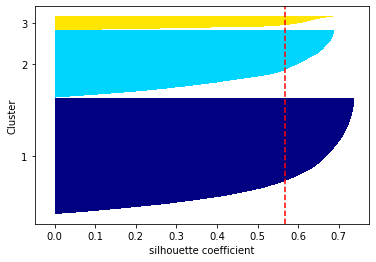

In [8]:
# https://qiita.com/deaikei/items/11a10fde5bb47a2cf2c2
from sklearn.metrics import silhouette_samples
from matplotlib import cm

cluster_labels = np.unique(y_km)
n_clusters=cluster_labels.shape[0]    

silhouette_vals = silhouette_samples(train_pca, y_km, metric='euclidean')  
y_ax_lower, y_ax_upper= 0,0
yticks = []

for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km==c]   
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)              
        color = cm.jet(float(i)/n_clusters)              
        plt.barh(range(y_ax_lower,y_ax_upper),            
                         c_silhouette_vals,               
                         height=1.0,                      
                         edgecolor='none',                
                         color=color)                     
        yticks.append((y_ax_lower+y_ax_upper)/2)          
        y_ax_lower += len(c_silhouette_vals)              

silhouette_avg = np.mean(silhouette_vals)                 
plt.axvline(silhouette_avg,color="red",linestyle="--")     
plt.yticks(yticks,cluster_labels + 1)                     
plt.ylabel('Cluster')
plt.xlabel('silhouette coefficient')
plt.show()

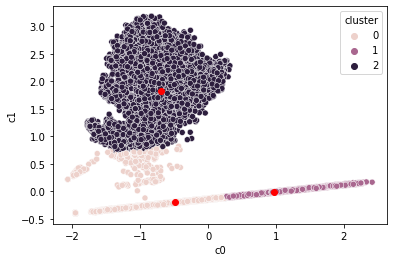

In [9]:
train_pca["cluster"] = y_km
test_pca["cluster"] = y_km_test

center = km.cluster_centers_

sns.scatterplot(data=train_pca, x="c0", y="c1", hue="cluster")
plt.plot(center[0, 0], center[0, 1], "bo", c="r")
plt.plot(center[1, 0], center[1, 1], "bo", c="r")
plt.plot(center[2, 0], center[2, 1], "bo", c="r")

plt.show()

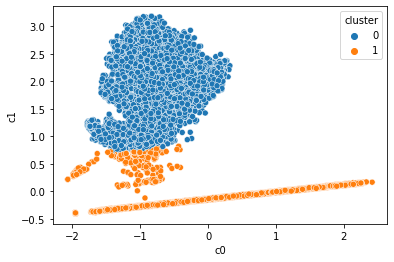

In [10]:
'''
Try to separate the coordinate space that exists in a straight line and 
the cluster that is randomly arranged
'''

train_pca["cluster"] = train_pca.cluster.apply(lambda x: 0 if x == 2 else 1)
test_pca["cluster"] = test_pca.cluster.apply(lambda x: 0 if x == 2 else 1)

sns.scatterplot(data=train_pca, x="c0", y="c1", hue="cluster")
plt.show()

In [11]:
'''
Let's try how it was isolated using the information obtained from the cluster
'''

# merge 
train_pca["breath_id"] = train_pca.index 
train_pca
train_pca.drop(["c0", "c1"], axis=1, inplace=True)

In [12]:
train_pca = train_pca.reset_index(drop=True)
train_pca

,cluster,breath_id
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
...,...,...
75445,1,125740
75446,1,125742
75447,1,125743
75448,1,125745


In [13]:
train = pd.merge(train, train_pca, how="left", on="breath_id")
train

,id,breath_id,R,C,time_step,u_in,u_out,pressure,cluster_x,log_u_in,time_step_class,cluster_y
0,1,1,20,50,0.000000,0.083334,0,5.837492,1,0.080043,0,1
1,2,1,20,50,0.033652,18.383041,0,5.907794,1,2.964399,0,1
2,3,1,20,50,0.067514,22.509278,0,7.876254,1,3.157395,0,1
3,4,1,20,50,0.101542,22.808822,0,11.742872,1,3.170056,0,1
4,5,1,20,50,0.135756,25.355850,0,12.234987,1,3.271690,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032,0,0.912168,2,0
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032,0,0.911679,2,0
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729,0,0.939608,2,0
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938,0,0.820952,2,0


In [14]:
# helper 
def find_cluster_r_c(df):
    fig, ax = plt.subplots(2, 2, figsize=(15, 6))
    for c in range(2):
        for r_c in range(2):
            x = df.loc[df.cluster == c, "R" if r_c == 0 else "C" ]
            sns.countplot(x, ax=ax[c][r_c])
            ax[c][r_c].set_title(f"Cluster={c}")
    plt.tight_layout()
    
    
def find_cluster_transition(df, is_train=True):
    fig, ax = plt.subplots(2, 5, figsize=(15, 6))
    for c in range(2):
        x = df.loc[df.cluster == c]
        breath = x.breath_id.unique()
        for n in range(5):
            if is_train:
                xx = x.loc[x.breath_id == breath[n], ["time_step", "u_in", "u_out", "pressure"]]
            else:
                xx = x.loc[x.breath_id == breath[n], ["time_step", "u_in", "u_out"]]
            xx.set_index("time_step").plot(ax=ax[c][n])
            ax[c][n].set_title(f"breath_id={breath[n]}")
            ax[c][n].set_xticks([])
            
            if n == 0:
                ax[c][n].set_ylabel(f"Cluster={c}")
    plt.tight_layout()

In [15]:
sns.countplot(train.cluster)

AttributeError: 'DataFrame' object has no attribute 'cluster'

AttributeError: 'DataFrame' object has no attribute 'cluster'

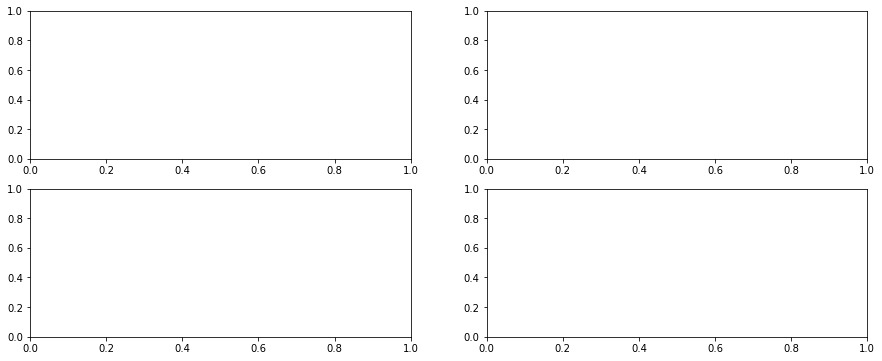

In [16]:
'''
Some clusters show a single attribute.
It is more strongly reflected in clusters that do not exist in a straight line.
'''

find_cluster_r_c(train)

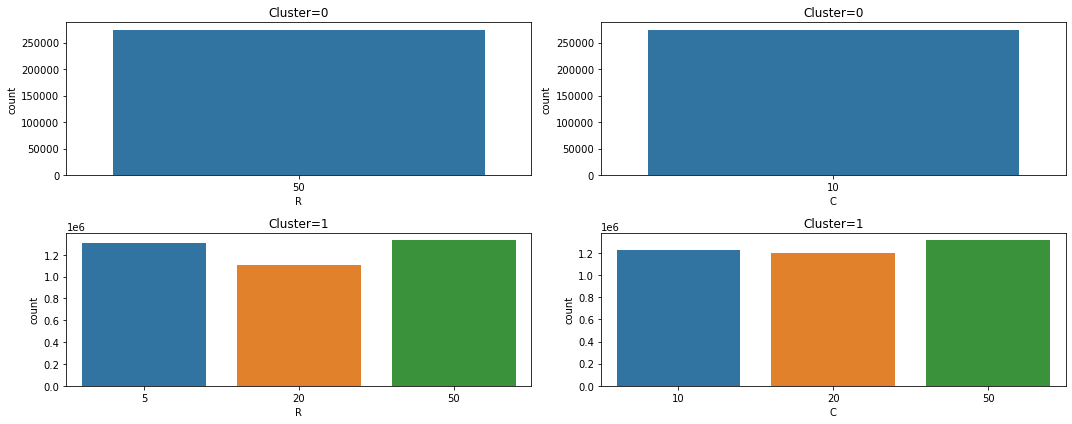

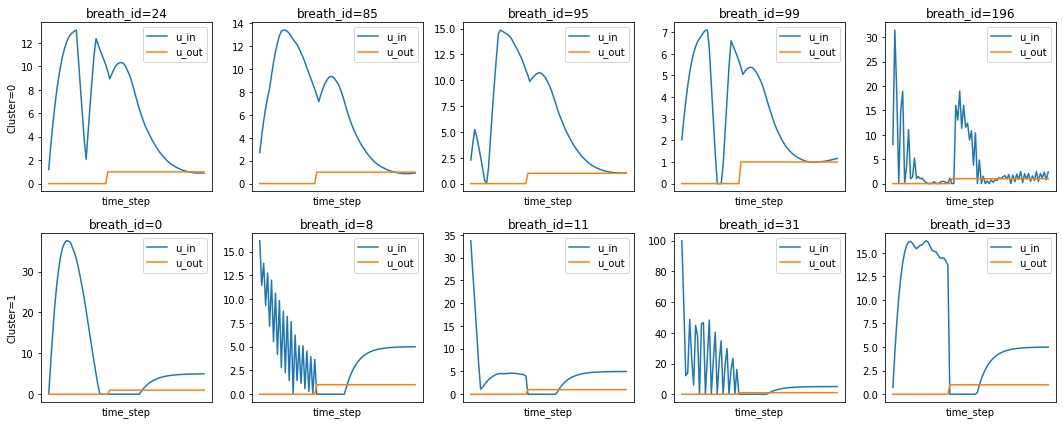

In [17]:
find_cluster_r_c(test)
find_cluster_transition(test, False)

In [19]:
'''
From the time-series data distribution,
we confirmed a sharp rise in u_in following 1.0 second. 
After that, it decreases smoothly.
'''

#find_cluster_transition(train)

train.drop(["time_step_class", "log_u_in"], axis=1, inplace=True)
test.drop(["time_step_class", "log_u_in"], axis=1, inplace=True)

train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)